In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timeit

df = pd.read_csv('{Csv file directory}/texts.csv', encoding='latin-1',header=0)
df.head(5)



,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home youâre drunk!!! @USER #M...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


In [19]:
df.drop(df.columns[0], axis=1,inplace=True)
df.head(5)

,tweet,subtask_a,subtask_b,subtask_c
0,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,@USER @USER Go home youâre drunk!!! @USER #M...,OFF,TIN,IND
2,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


In [20]:
df.drop(df.columns[2], axis=1,inplace=True)
df.head(5)

,tweet,subtask_a,subtask_c
0,@USER She should ask a few native Americans wh...,OFF,NaN
1,@USER @USER Go home youâre drunk!!! @USER #M...,OFF,IND
2,Amazon is investigating Chinese employees who ...,NOT,NaN
3,"@USER Someone should'veTaken"" this piece of sh...",OFF,NaN
4,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN


In [21]:
df.drop(df.columns[2], axis=1,inplace=True)
df.head(5)

,tweet,subtask_a
0,@USER She should ask a few native Americans wh...,OFF
1,@USER @USER Go home youâre drunk!!! @USER #M...,OFF
2,Amazon is investigating Chinese employees who ...,NOT
3,"@USER Someone should'veTaken"" this piece of sh...",OFF
4,@USER @USER Obama wanted liberals &amp; illega...,NOT


In [22]:
df=pd.get_dummies(df,columns=["subtask_a"])
df.head()

,tweet,subtask_a_NOT,subtask_a_OFF
0,@USER She should ask a few native Americans wh...,0,1
1,@USER @USER Go home youâre drunk!!! @USER #M...,0,1
2,Amazon is investigating Chinese employees who ...,1,0
3,"@USER Someone should'veTaken"" this piece of sh...",0,1
4,@USER @USER Obama wanted liberals &amp; illega...,1,0


In [23]:
df.drop(df.columns[1], axis=1,inplace=True)
df.head(5)

,tweet,subtask_a_OFF
0,@USER She should ask a few native Americans wh...,1
1,@USER @USER Go home youâre drunk!!! @USER #M...,1
2,Amazon is investigating Chinese employees who ...,0
3,"@USER Someone should'veTaken"" this piece of sh...",1
4,@USER @USER Obama wanted liberals &amp; illega...,0


In [24]:
import re

def text_cleaning(text):
  text = re.sub(r'@[A-Za-z0-9]+', '', text)     # removing @mentions
  text = re.sub(r'@[A-Za-zA-Z0-9]+', '', text)  # removing @mentions 
  text = re.sub(r'@[A-Za-z]+', '', text)        # removing @mentions
  text = re.sub(r'@[-)]+', '', text)            # removing @mentions
  text = re.sub(r'#', '', text )                # removing '#' sign
  text = re.sub(r'RT[\s]+', '', text)           # removing RT
  text = re.sub(r'https?\/\/\S+', '', text)     # removing the hyper link
  text = re.sub(r'&[a-z;]+', '', text)          # removing '&gt;'

  return text

In [25]:
df.iloc[:,0] = df.iloc[:,0].apply(text_cleaning)
df.head()

,tweet,subtask_a_OFF
0,She should ask a few native Americans what th...,1
1,Go home youâre drunk!!! MAGA Trump2020 ð...,1
2,Amazon is investigating Chinese employees who ...,0
3,"Someone should'veTaken"" this piece of shit to...",1
4,Obama wanted liberals illegals to move into...,0


In [26]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,0].values, df.iloc[:,1].values, test_size=0.30)

print('Text: ', x_train[0])
print('Offensive: ', y_train[0])

Text:     Planned Parenthood provides millions with CONTRACEPTION - thereby eliminating an unplanned pregnancy for most; an unplanned pregnancy that doesnât potentially result in an abortion.  Conservatives possess no critical thinking skills whatsoever!
Offensive:  0


In [27]:
# converting the strings into integers using Tokenizer 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 

max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(x_train)

wordidx = tokenizer.word_index
V = len(wordidx)
print('The size of datatset vocab is: ', V)

The size of datatset vocab is:  17394


In [28]:
train_seq = tokenizer.texts_to_sequences(x_train)
test_seq = tokenizer.texts_to_sequences(x_test)

# padding the traing sequence
pad_train = pad_sequences(train_seq)
T = pad_train.shape[1]
print('The length of training sequence is: ', T)

# padding the test sequence
pad_test = pad_sequences(test_seq, maxlen=T)
print('The length of testing sequence is: ', pad_test.shape[1])

The length of training sequence is:  62
The length of testing sequence is:  62


In [29]:
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, GlobalMaxPooling1D
from tensorflow.keras.models import Model

D = 20 
M = 15

i = Input (shape=(T, ))   
x = Embedding(V+1, 20)(i)   
x = LSTM(15, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(32, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i,x)

# compiling the model
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# training the model
r = model.fit(pad_train, y_train, validation_data=(pad_test, y_test), epochs=5)

Epoch 1/5
290/290 [==============================] - 8s 21ms/step - loss: 0.6407 - accuracy: 0.6634 - val_loss: 0.6259 - val_accuracy: 0.6772
Epoch 2/5
290/290 [==============================] - 6s 20ms/step - loss: 0.6356 - accuracy: 0.6636 - val_loss: 0.6219 - val_accuracy: 0.6772
Epoch 3/5
290/290 [==============================] - 6s 20ms/step - loss: 0.5814 - accuracy: 0.6972 - val_loss: 0.5176 - val_accuracy: 0.7528
Epoch 4/5
290/290 [==============================] - 6s 20ms/step - loss: 0.4022 - accuracy: 0.8235 - val_loss: 0.5192 - val_accuracy: 0.7654
Epoch 5/5
290/290 [==============================] - 6s 21ms/step - loss: 0.2875 - accuracy: 0.8864 - val_loss: 0.5907 - val_accuracy: 0.7487


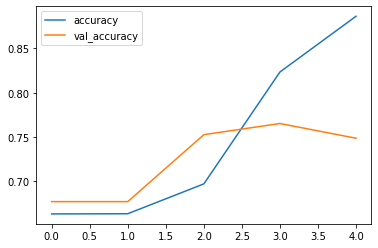

In [30]:
plt.plot(r.history['accuracy'], label= 'accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [31]:
#model.save('offensive language.h5')
scores = model.evaluate(pad_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 74.87%


In [32]:
def predict_sentiment(text):
  start = timeit.default_timer()
  text_seq = tokenizer.texts_to_sequences(text)
  text_pad = pad_sequences(text_seq, maxlen=T)

  predicted = model.predict(text_pad).round()

  if predicted == 1.0:
    print('Offensive')
  else:
    print('Not Offensive')
  stop = timeit.default_timer()
  execution_time = stop - start
  print("Time required for Execution -> ", execution_time, "seconds")
text = ['I am a student']
predict_sentiment(text)

Not Offensive
Time required for Execution ->  0.2807350000000497 seconds
